This notebook is for our first Classification model. We will start with a basic CNN model just to test that our structure is set up properly. This file may be adjusted and/or replaced before we turn in Milestone 3.

In [9]:
# Install libraries
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install scikit-image scikit-learn

^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, 

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

2024-03-16 05:20:59.907232: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 05:21:00.093596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 05:21:00.093619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 05:21:00.103128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 05:21:00.121424: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# ./cvpr_depth/bathroom, bedroom, etc
import torch
from typing import List
from PIL import Image
from skimage.transform import resize_local_mean

home_image_folders_str = """bathroom
bedroom
children_room
corridor
dining_room
garage
kitchen
laundry
livingroom
nursery
pantry
"""
home_room_folders = home_image_folders_str.split('\n')

from pathlib import Path
import os
def enumerate_data_folder(folder: str) -> List[Path]:
    path = Path(f"../data/cvpr_raw/indoorCVPR_09/Images/{folder}")
    return list(path.glob("*"))

def get_all_data():
    out = []
    for folder in home_room_folders:
        print(f"Reading folder {folder}")
        for image_path in enumerate_data_folder(folder):
            if not os.path.isfile(image_path):
                continue

            img = np.asarray(Image.open(image_path).convert('RGB'))
            if img.dtype != np.uint8 and img.dtype != np.int8:
                print(f"got unrecognized image dtype {img.dtype}")
            img = img.astype(np.float32)
            # scale RGB values to [0, 1]
            img = img / 255.
            depth = torch.load(f"./cvpr_depth/{folder}/{image_path.name}.pt").cpu().numpy().squeeze()

            img = resize_local_mean(img, output_shape=(64, 64))
            depth = resize_local_mean(depth, output_shape=(64, 64))

            depth = depth.reshape((64, 64, 1))

            final = np.concatenate((img, depth), axis=-1)
            out.append((final, folder))
    return out


data = get_all_data()
data

Reading folder bathroom
Reading folder bedroom
Reading folder children_room
Reading folder corridor
Reading folder dining_room
Reading folder garage
Reading folder kitchen
Reading folder laundry
Reading folder livingroom
Reading folder nursery
Reading folder pantry
Reading folder 


[]

In [ ]:
X = []
y = []
for arr, label in data:
    X.append(arr)
    y.append(label)

X = np.asarray(X)
y = np.asarray(y)
display(X)
display(y)
display(X.shape)
display(y.shape)

array([], dtype=float64)

array([], dtype=float64)

(0,)

(0,)

In [ ]:
#from sklearn.preprocessing import OneHotEncoder

#encoder = OneHotEncoder(sparse_output=False)
#encoder.fit_transform(X=np.asarray(list(set(y))).reshape(-1, 1))
#y = encoder.transform(y.reshape(-1, 1))
#y.shape

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Split the data into test and train
# np.savez("./scaled_processed_data.npz", X=X, y=y)
data = np.load("scaled_processed_data.npz")
X = data["X"]
y = data["y"]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
y

Shape of X: (3653, 64, 64, 4)
Shape of y: (3653,)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
# test 
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=983)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

rgb_input = Input(shape=(64, 64, 3))
depth_input = Input(shape=(64, 64, 1))

# RGB layers
rgb_stream = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.001), strides=(1,1))(rgb_input)
rgb_stream = BatchNormalization()(rgb_stream)
rgb_stream = MaxPooling2D(pool_size=(2, 2))(rgb_stream)
# rgb_stream = Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', kernel_regularizer=l1(0.001), strides=(1,1))(rgb_stream)
# rgb_stream = BatchNormalization()(rgb_stream)
# rgb_stream = MaxPooling2D(pool_size=(2, 2))(rgb_stream)
rgb_stream = Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001), strides=(1,1))(rgb_stream)
rgb_stream = BatchNormalization()(rgb_stream)
rgb_stream = MaxPooling2D(pool_size=(2, 2))(rgb_stream)
rgb_stream = Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001), strides=(1,1))(rgb_stream)
rgb_stream = BatchNormalization()(rgb_stream)
rgb_stream = MaxPooling2D(pool_size=(2, 2))(rgb_stream)

# Depth layers
depth_stream = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.001), strides=(1,1))(depth_input)
depth_stream = BatchNormalization()(depth_stream)
depth_stream = MaxPooling2D(pool_size=(2, 2))(depth_stream)
# depth_stream = Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', kernel_regularizer=l1(0.001), strides=(1,1))(depth_stream)
# depth_stream = BatchNormalization()(depth_stream)
# depth_stream = MaxPooling2D(pool_size=(2, 2))(depth_stream)
depth_stream = Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001), strides=(1,1))(depth_stream)
depth_stream = BatchNormalization()(depth_stream)
depth_stream = MaxPooling2D(pool_size=(2, 2))(depth_stream)
depth_stream = Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001), strides=(1,1))(depth_stream)
depth_stream = BatchNormalization()(depth_stream)
depth_stream = MaxPooling2D(pool_size=(2, 2))(depth_stream)

combined = Concatenate()([rgb_stream, depth_stream])
combined = Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001), strides=(1, 1))(combined)
combined = Dropout(0.3)(combined)
combined = BatchNormalization()(combined)
combined = GlobalAveragePooling2D()(combined)
combined = Dropout(0.25)(combined)
# combined = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(combined)
# combined = Dropout(0.3)(combined)
combined = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
combined = Dropout(0.2)(combined)
combined = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
combined = Dropout(0.2)(combined)
combined = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)

output_layer = Dense(10, activation='softmax')(combined)

model = Model(inputs=[rgb_input, depth_input], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

X_train_rgb = X_train[:, :, :, :3]
X_train_depth = X_train[:, :, :, 3:]
X_test_rgb = X_test[:, :, :, :3]
X_test_depth = X_test[:, :, :, 3:]

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with data augmentation
batch_size = 32
epochs = 125
history = model.fit(
    datagen.flow([X_train_rgb, X_train_depth], y_train, batch_size=batch_size),
    validation_data=([X_test_rgb, X_test_depth], y_test),
    epochs=epochs,
    callbacks=[lr_scheduler]
)

(2922, 64, 64, 4)

(731, 64, 64, 4)

(2922, 10)

(731, 10)

Epoch 1/125


2024-03-16 05:43:18.543142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 [==============================] - 4s 16ms/step - loss: 3.0215 - accuracy: 0.2348 - val_loss: 3.0445 - val_accuracy: 0.1765 - lr: 1.0000e-04
Epoch 2/125
92/92 [==============================] - 1s 14ms/step - loss: 2.7360 - accuracy: 0.3371 - val_loss: 3.1267 - val_accuracy: 0.2011 - lr: 1.0000e-04
Epoch 3/125
92/92 [==============================] - 1s 14ms/step - loss: 2.5496 - accuracy: 0.4008 - val_loss: 3.3681 - val_accuracy: 0.2038 - lr: 1.0000e-04
Epoch 4/125
92/92 [==============================] - 1s 14ms/step - loss: 2.4327 - accuracy: 0.4343 - val_loss: 3.3246 - val_accuracy: 0.2503 - lr: 1.0000e-04
Epoch 5/125
92/92 [==============================] - 1s 14ms/step - loss: 2.3355 - accuracy: 0.4524 - val_loss: 3.1294 - val_accuracy: 0.2503 - lr: 1.0000e-04
Epoch 6/125
92/92 [==============================] - 1s 14ms/step - loss: 2.2672 - accuracy: 0.4802 - val_loss: 2.6375 - val_accuracy: 0.3119 - lr: 1.0000e-04
Epoch 7/125
92/92 [==============================] - 1s 14

In [17]:
test_loss, test_acc = model.evaluate([X_test_rgb, X_test_depth], y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


23/23 [==============================] - 0s 2ms/step - loss: 1.7464 - accuracy: 0.6566
Test Loss: 1.74640953540802
Test Accuracy: 0.6566347479820251


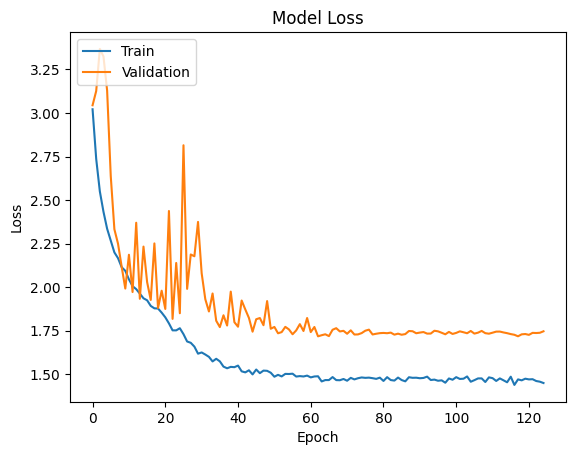

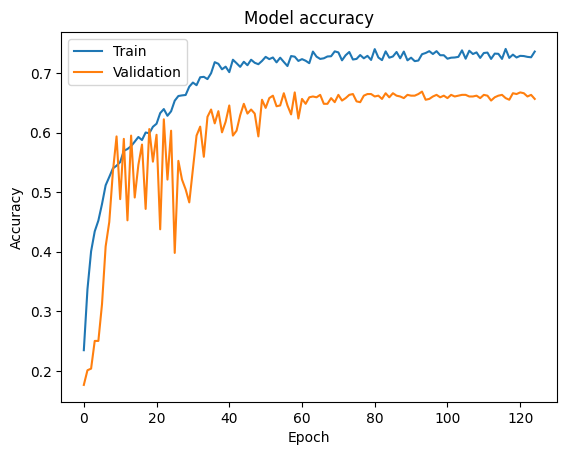

In [18]:
def plot_loss_metrics(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


plot_loss_metrics(history)